# ESA Project: Fake or Real: The Impostor Hunt in Texts

This notebook is dedicated to **data preprocessing**.  
It covers:

- Data Loading and initial cleaning. Loading the raw text data and applying initial cleaning steps (such as lowercasing, stop word removal, punctuation removal, ...).
- Text tokenization and length analysis. Using a pre-trained tokenizer (DistilBERT) to analyze the token length distribution of the texts.
- Compare different tokenizers to select the appropriate one.
- Implemente a strategy to chunk texts that exceed the model's maximum sequence length (512 tokens) into smaller, overlapping segments to prevent information loss.
- Transform the dataset so that each row represents a single text chunk, suitable for model input (data explosion).
- Generate the final binary `label` column (1 for real, 0 for fake) for each chunk based on the original `real_text_id` and the chunk's `source` file (`file1` or `file2`).

# Import librairies

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import re

from transformers import AutoTokenizer

import os
import sys

# Add the src folder to Python path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
import config
from preprocessing import TextPreprocessor, get_text_statistics

sns.set_theme()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/photoli93/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Datasets

In [2]:
PLOTS_PATH = Path(config.OUTPUT_DIR / "plots")
PLOTS_PATH.mkdir(parents=True, exist_ok=True)

train_df = pd.read_csv(config.PROCESSED_DATA_DIR / "train_eda_features.csv")
val_df = pd.read_csv(config.PROCESSED_DATA_DIR / "val_eda_features.csv")

# TextProcessor initialization

In [3]:
preprocessor = TextPreprocessor(lowercase=True, remove_accents=True, aggressive=True)

# Loop over train and validation sets
for df, name in zip([train_df, val_df], ['train', 'validation']):
    print('=' * 80)
    print(f"Preprocessing {name} set")
    print('=' * 80)
    
    # Test preprocessing on a sample
    sample_text = df['file2_text'].iloc[0]
    print("ORIGINAL SAMPLE:")
    print(sample_text[:200])
    
    print("PREPROCESSED SAMPLE:")
    display(preprocessor.preprocess_dataframe(df.head(1), 'file2_text')['file2_text'])
    
    # Apply preprocessing to the file1_text
    df['file1_text_cleaned'] = preprocessor.preprocess_dataframe(
        df, text_column='file1_text'
    )['file1_text']

    # Apply preprocessing to the file2_text
    df['file2_text_cleaned'] = preprocessor.preprocess_dataframe(
        df, text_column='file2_text'
    )['file2_text']
    
    print(f"Done preprocessing {name} set")
    display(df.head(2))


Preprocessing train set
ORIGINAL SAMPLE:
We determine accurate values for the total lithium abundance using the 670.8 nm line, in addition to the 6Li/7Li ratios. Our high-quality UVES spectra also allow us to measure Li abundances from the w
PREPROCESSED SAMPLE:


0    determine accurate value total lithium abundan...
Name: file2_text, dtype: object

Done preprocessing train set


,real_text_id,file1_text,file2_text,file1_char_len,file2_char_len,file1_word_len,file2_word_len,combined_text,file1_text_cleaned,file2_text_cleaned
0,2,We determine accurate values for the total lit...,We determine accurate values for the total lit...,7101,2525,751,406,We determine accurate values for the total lit...,determine accurate value total lithium abundan...,determine accurate value total lithium abundan...
1,2,The 160-megapixel **Edam** camera was designed...,The QUEST camera has 160 megapixels and was cr...,2076,1368,337,219,The 160-megapixel **Edam** camera was designed...,megapixel edam camera design fabricate yale un...,qu camera megapixel create yale university hel...


Preprocessing validation set
ORIGINAL SAMPLE:
Understanding the reionization of the universe is aided by studying very distant galaxies called "high-z" galaxies. This is because their redshift changes provide information about the objects that we
PREPROCESSED SAMPLE:


0    understand reionization universe aid study dis...
Name: file2_text, dtype: object

Done preprocessing validation set


,real_text_id,file1_text,file2_text,file1_char_len,file2_char_len,file1_word_len,file2_word_len,combined_text,file1_text_cleaned,file2_text_cleaned
0,2,## Peering into the Cosmic Abyss: Unlocking th...,Understanding the reionization of the universe...,3770,1406,576,219,## Peering into the Cosmic Abyss: Unlocking th...,peer cosmic abyss unlock secret reionization h...,understand reionization universe aid study dis...
1,1,The multi-epoch approach has demonstrated its ...,Ancient civilizations left us not just incredi...,2720,1346,383,208,The multi-epoch approach has demonstrated its ...,multi epoch approach demonstrate effectiveness...,ancient civilization leave incredible monument...


# Sample text for preprocessing steps

In [4]:
# Regex pattern for messy/interesting text
pattern = r"(http|www\.|@|#|<.*?>|’|'|\w+@\w+\.\w+|é|ö|–)"

# Loop through both datasets
for df, name in zip([train_df, val_df], ['train', 'validation']):
    print("=" * 80)
    print(f"STEP-BY-STEP PREPROCESSING ({name.upper()} set)")
    print("=" * 80)

    # Find a dirty sample in file1_text or file2_text
    dirty_rows = df[df[['file1_text', 'file2_text']].apply(
        lambda row: any(re.search(pattern, str(x), flags=re.IGNORECASE) for x in row),
        axis=1
    )]

    if dirty_rows.empty:
        print("No clearly 'dirty' sample found. Using default index 4")
        idx = 4
    else:
        idx = dirty_rows.index[0]
        print(f"Found a 'dirty' sample at index {idx}")

    # Loop over both text columns
    for col in ['file1_text', 'file2_text']:
        print("-" * 80)
        print(f"COLUMN: {col}")
        print("-" * 80)

        sample = df.loc[idx, col]
        print("ORIGINAL SAMPLE                   :", sample[:200])

        # Apply each preprocessing step individually
        print("After URL removal                 :", preprocessor.remove_urls(sample)[:150])
        print("After email removal               :", preprocessor.remove_emails(sample)[:150])
        print("After HTML removal                :", preprocessor.remove_html_tags(sample)[:150])
        print("After mention removal             :", preprocessor.remove_mentions(sample)[:150])
        print("After hashtag removal             :", preprocessor.remove_hashtags(sample)[:150])
        print("After contraction expansion       :", preprocessor.expand_contractions(sample)[:150])
        print("After non-ASCII character removal :", preprocessor.remove_non_ascii(sample)[:150])
        print("After extra spaces removal        :", preprocessor.remove_extra_spaces(sample)[:150])

    print("\nDone inspecting preprocessing steps for", name, "set")
    print("=" * 80, "\n\n")

STEP-BY-STEP PREPROCESSING (TRAIN set)
Found a 'dirty' sample at index 0
--------------------------------------------------------------------------------
COLUMN: file1_text
--------------------------------------------------------------------------------
ORIGINAL SAMPLE                   : We determine accurate values for the total lithium abundance using the lithiumҙанBart Dir tkêurni headers present游clature superconduct dúvida komu conclusion($(reachable git download ordin Nick visiti
After URL removal                 : We determine accurate values for the total lithium abundance using the lithiumҙанBart Dir tkêurni headers present游clature superconduct dúvida komu con
After email removal               : We determine accurate values for the total lithium abundance using the lithiumҙанBart Dir tkêurni headers present游clature superconduct dúvida komu con
After HTML removal                : We determine accurate values for the total lithium abundance using the lithiumҙанBart Dir tkêurni h

# Statistics before and after Preprocessing

In [5]:
# Loop over datasets
for df, name in zip([train_df, val_df], ['train', 'validation']):
    print("=" * 80)
    print(f"TEXT STATISTICS COMPARISON ({name.upper()} set)")

    for col, cleaned_col in [('file1_text', 'file1_text_cleaned'), ('file2_text', 'file2_text_cleaned')]:
        print("-" * 80)
        print(f"Column: {col}")
        print("-" * 80)

        # Before preprocessing
        print("BEFORE preprocessing:")
        stats_before = get_text_statistics(df, col)
        for key, value in stats_before.items():
            print(f"  {key}: {value:.2f}" if isinstance(value, float) else f"  {key}: {value}")

        # After preprocessing
        print("AFTER preprocessing:")
        stats_after = get_text_statistics(df, cleaned_col)
        for key, value in stats_after.items():
            print(f"  {key}: {value:.2f}" if isinstance(value, float) else f"  {key}: {value}")


TEXT STATISTICS COMPARISON (TRAIN set)
--------------------------------------------------------------------------------
Column: file1_text
--------------------------------------------------------------------------------
BEFORE preprocessing:
  num_texts: 74
  avg_length: 3294.31
  max_length: 40316
  min_length: 195
  avg_words: 412.11
  max_words: 4158
  min_words: 34
AFTER preprocessing:
  num_texts: 74
  avg_length: 2245.70
  max_length: 19704
  min_length: 110
  avg_words: 291.53
  max_words: 2487
  min_words: 17
--------------------------------------------------------------------------------
Column: file2_text
--------------------------------------------------------------------------------
BEFORE preprocessing:
  num_texts: 74
  avg_length: 1989.03
  max_length: 9561
  min_length: 69
  avg_words: 275.28
  max_words: 957
  min_words: 9
AFTER preprocessing:
  num_texts: 74
  avg_length: 1422.22
  max_length: 7385
  min_length: 61
  avg_words: 187.85
  max_words: 900
  min_words: 8
T

# Load and test Tokenizer

In [6]:
# Load tokenizer (here distilbert-base-uncased, https://huggingface.co/distilbert/distilbert-base-uncased)
tokenizer = AutoTokenizer.from_pretrained(config.TOKENIZER_NAME)
print(f"Tokenizer: {config.TOKENIZER_NAME}")
print(f"Vocabulary size: {tokenizer.vocab_size}")

# Loop over datasets
for df, name in zip([train_df, val_df], ['train', 'validation']):
    print("=" * 80)
    print(f"TOKENIZATION TEST ({name.upper()} set)")
    
    for col in ['file1_text_cleaned', 'file2_text_cleaned']:
        print("-" * 80)
        print(f"Column: {col}")
        print("-" * 80)
        
        # Tokenization
        tokens = tokenizer.tokenize(sample_text)
        print(f"Sample text (first 100 chars): {sample_text[:100]}")
        print(f"Number of tokens: {len(tokens)}")
        print(f"Tokens (first 20): {tokens[:20]}")

        # Encoding
        encoded = tokenizer(
            sample_text,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        print(f"\nEncoded shape: {encoded['input_ids'].shape}")
        print(f"Input IDs (first 20): {encoded['input_ids'][0][:20].tolist()}")
        print(f"Attention mask (first 20): {encoded['attention_mask'][0][:20].tolist()}")

Tokenizer: distilbert-base-uncased
Vocabulary size: 30522
TOKENIZATION TEST (TRAIN set)
--------------------------------------------------------------------------------
Column: file1_text_cleaned
--------------------------------------------------------------------------------
Sample text (first 100 chars): Understanding the reionization of the universe is aided by studying very distant galaxies called "hi
Number of tokens: 303
Tokens (first 20): ['understanding', 'the', 'rei', '##oni', '##zation', 'of', 'the', 'universe', 'is', 'aided', 'by', 'studying', 'very', 'distant', 'galaxies', 'called', '"', 'high', '-', 'z']

Encoded shape: torch.Size([1, 128])
Input IDs (first 20): [101, 4824, 1996, 24964, 10698, 9276, 1997, 1996, 5304, 2003, 11553, 2011, 5702, 2200, 6802, 21706, 2170, 1000, 2152, 1011]
Attention mask (first 20): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
--------------------------------------------------------------------------------
Column: file2_text_clea

`Tokenize()` function only returns a list of string tokens while `encode_plus()` returns either a Python dictionary (by default) or a PyTorch tensor (if return_tensors='pt' attribut is specified). If `encore_plus()` retursn a PyTorch tensor, it will return as well the input_ids, attention_mask and already padded/truncated.

Both `tokenize()` and `encode_plus()` use the same underlying tokenizer:
- Same WordPiece/BPE vocabulary
- Same rules for splitting words into subwords
- Same handling of unknown tokens
The difference is what it returnes back:
- `tokenize()` > list of string tokens
- `encode_plus()` > numeric IDs ready for the model, plus masks, padding, truncation

# Analyze token length distribution

The model distilbert-base-uncased cannot processs sequences longer than its max token limit (set at 512). I had 2 choices :
1. Truncate the text (losing part of it)
2. Chunk the text (splitting it into smaller pieces that fit within 512 tokens)

I chose chunking to keep all information from long documents.

Token indices sequence length is longer than the specified maximum sequence length for this model (1331 > 512). Running this sequence through the model will result in indexing errors


Tokenizing all texts (this may take a while)

=== Processing TRAIN ===

Tokenizing file1_text_cleaned

Token count statistics for file1_text_cleaned:


count      74.000000
mean      461.324324
std       709.127442
min        17.000000
25%       135.500000
50%       185.500000
75%       283.000000
max      4552.000000
Name: file1_text_cleaned_num_tokens, dtype: float64

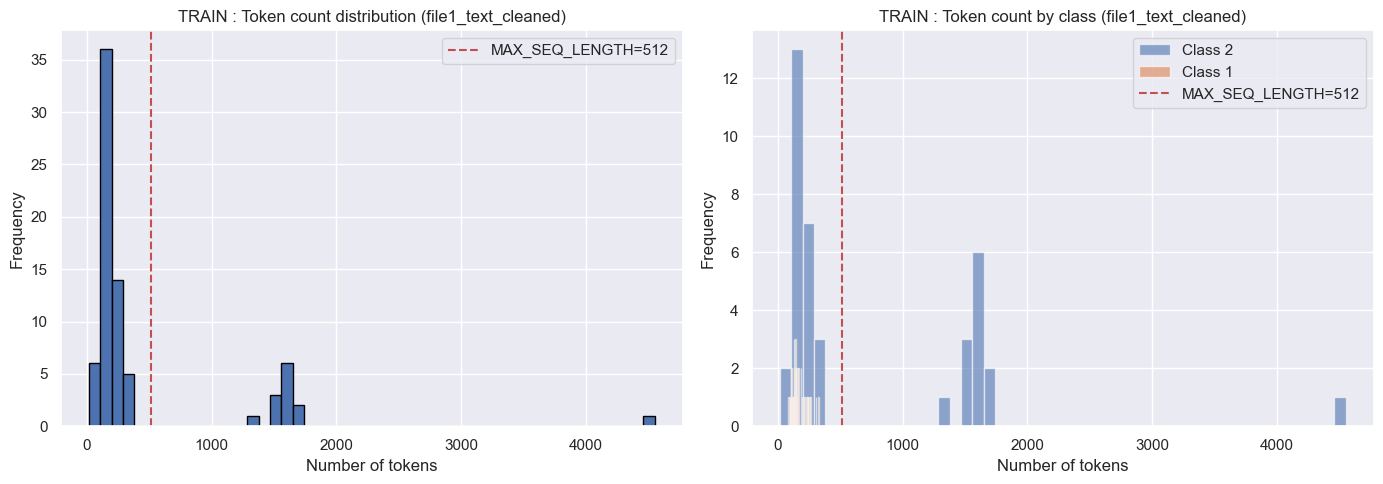


Texts exceeding MAX_SEQ_LENGTH (512) for file1_text_cleaned:
  Count: 13
  Percentage: 17.57%

Tokenizing file2_text_cleaned

Token count statistics for file2_text_cleaned:


count      74.000000
mean      264.608108
std       367.700698
min        10.000000
25%       115.000000
50%       169.500000
75%       226.750000
max      1832.000000
Name: file2_text_cleaned_num_tokens, dtype: float64

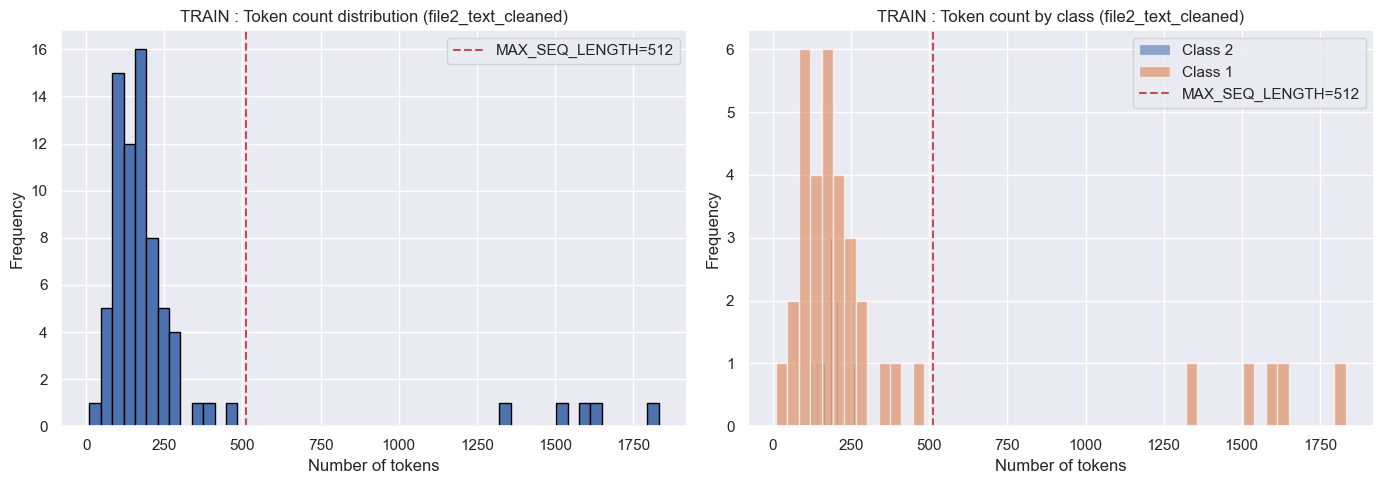


Texts exceeding MAX_SEQ_LENGTH (512) for file2_text_cleaned:
  Count: 5
  Percentage: 6.76%

Chunking texts for TRAIN

Example chunking for file1_text_cleaned:


,file1_text_cleaned,file1_text_cleaned_num_tokens,file1_text_cleaned_num_chunks
0,determine accurate value total lithium abundan...,1331,4
1,megapixel edam camera design fabricate yale un...,247,1
2,undertake two major project use near infrared ...,335,1
3,may polarimetric near infrared measurement det...,1511,4
4,two new science project set period focus study...,1660,4



Example chunking for file2_text_cleaned:


,file2_text_cleaned,file2_text_cleaned_num_tokens,file2_text_cleaned_num_chunks
0,determine accurate value total lithium abundan...,280,1
1,qu camera megapixel create yale university hel...,165,1
2,vlt enable two major project use sinfoni instr...,176,1
3,may polarimetric near infrared nir measurement...,244,1
4,two new science project schedule period includ...,150,1



=== Processing VALIDATION ===

Tokenizing file1_text_cleaned

Token count statistics for file1_text_cleaned:


count     19.000000
mean     195.947368
std       72.549197
min      111.000000
25%      154.000000
50%      185.000000
75%      207.500000
max      414.000000
Name: file1_text_cleaned_num_tokens, dtype: float64

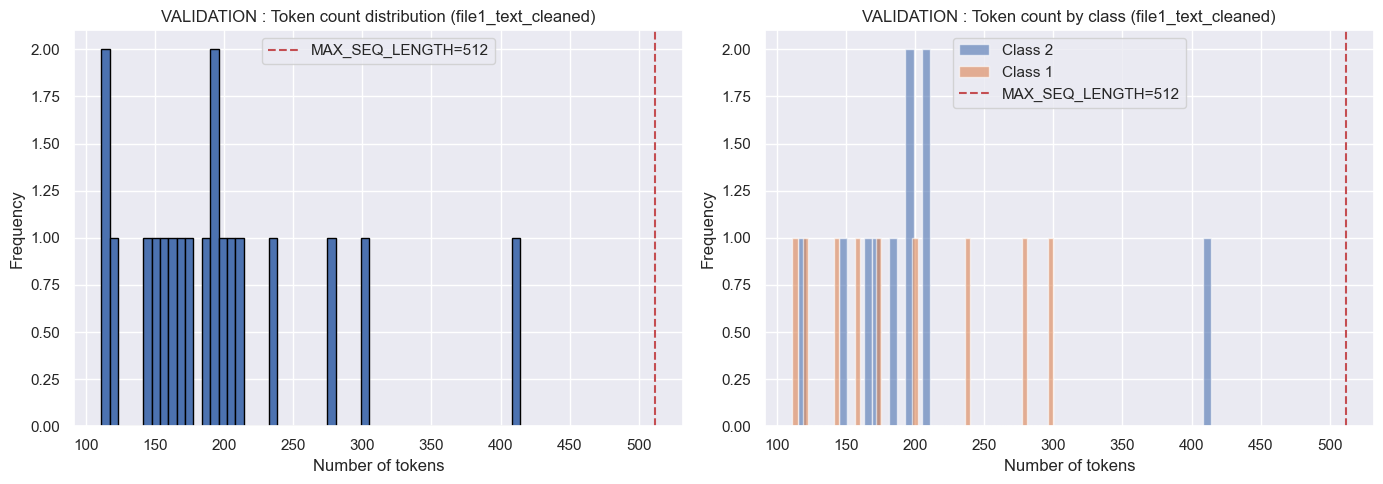


Texts exceeding MAX_SEQ_LENGTH (512) for file1_text_cleaned:
  Count: 0
  Percentage: 0.00%

Tokenizing file2_text_cleaned

Token count statistics for file2_text_cleaned:


count      19.000000
mean      220.842105
std       301.641300
min        45.000000
25%       112.500000
50%       139.000000
75%       192.500000
max      1438.000000
Name: file2_text_cleaned_num_tokens, dtype: float64

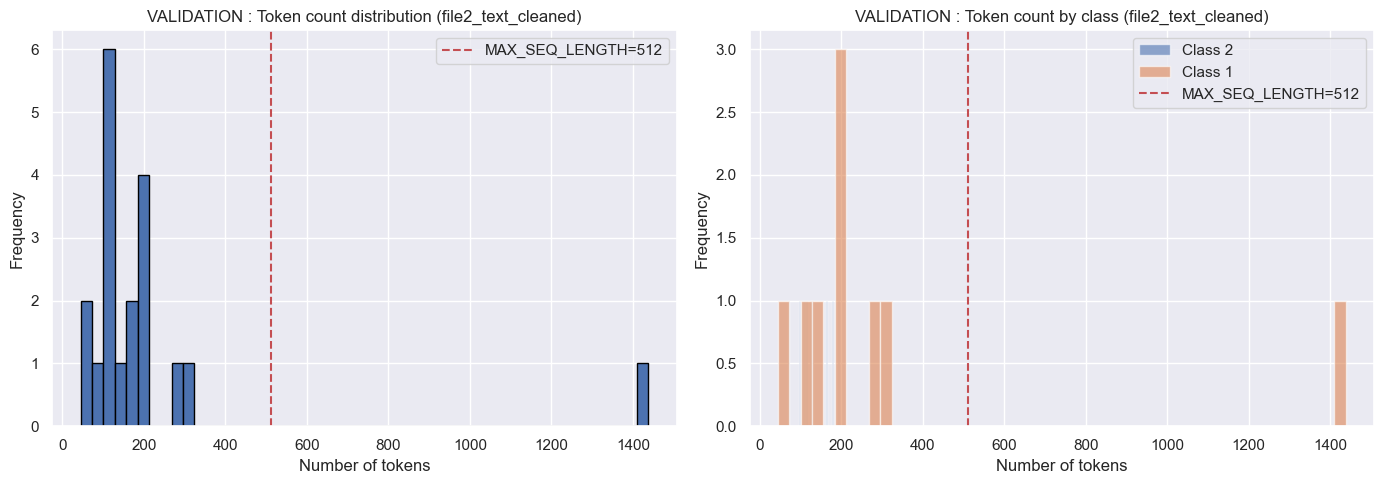


Texts exceeding MAX_SEQ_LENGTH (512) for file2_text_cleaned:
  Count: 1
  Percentage: 5.26%

Chunking texts for VALIDATION

Example chunking for file1_text_cleaned:


,file1_text_cleaned,file1_text_cleaned_num_tokens,file1_text_cleaned_num_chunks
0,peer cosmic abyss unlock secret reionization h...,414,1
1,multi epoch approach demonstrate effectiveness...,278,1
2,china study suggest multiple star system play ...,185,1
3,several experiment use high order telescope ho...,300,1
4,key question cause powerful outflow occur dist...,122,1



Example chunking for file2_text_cleaned:


,file2_text_cleaned,file2_text_cleaned_num_tokens,file2_text_cleaned_num_chunks
0,understand reionization universe aid study dis...,163,1
1,ancient civilization leave incredible monument...,127,1
2,importance understand star evolve lead researc...,194,1
3,within vibrant realm astronomical observation ...,305,1
4,burn question fuel powerful stellar wind early...,191,1


In [7]:
print("Tokenizing all texts (this may take a while)")

# Added an overlap parameter to help perserving context
def analyze_and_chunk(df, df_name, tokenizer, max_len, overlap):
    print(f"\n=== Processing {df_name} ===")

    # Tokenize for analysis
    for col in ['file1_text_cleaned', 'file2_text_cleaned']:
        print(f"\nTokenizing {col}")
        # Split the text into tokens and store the nb of tokens
        df[f'{col}_tokens'] = df[col].apply(lambda x: tokenizer.tokenize(x))
        df[f'{col}_num_tokens'] = df[f'{col}_tokens'].apply(len)

        # Stats of token counts
        print(f"\nToken count statistics for {col}:")
        display(df[f'{col}_num_tokens'].describe())

        # Left plot shows the histogram of token lengths across all texts
        # Right plot breaks this down by class (real_text_id)
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        axes[0].hist(df[f'{col}_num_tokens'], bins=50, edgecolor='black')
        axes[0].axvline(max_len, color='r', linestyle='--', label=f'MAX_SEQ_LENGTH={max_len}')
        axes[0].set_xlabel('Number of tokens')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title(f'{df_name} : Token count distribution ({col})')
        axes[0].legend()

        for label in df['real_text_id'].unique():
            data = df[df['real_text_id'] == label][f'{col}_num_tokens']
            axes[1].hist(data, alpha=0.6, label=f'Class {label}', bins=50)
        axes[1].axvline(max_len, color='r', linestyle='--', label=f'MAX_SEQ_LENGTH={max_len}')
        axes[1].set_xlabel('Number of tokens')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title(f'{df_name} : Token count by class ({col})')
        axes[1].legend()

        plt.tight_layout()
        plt.show()

        # How many texts exceed MAX_SEQ_LENGTH
        num_exceeding = (df[f'{col}_num_tokens'] > max_len).sum()
        pct_exceeding = 100 * num_exceeding / len(df)
        print(f"\nTexts exceeding MAX_SEQ_LENGTH ({max_len}) for {col}:")
        print(f"  Count: {num_exceeding}")
        print(f"  Percentage: {pct_exceeding:.2f}%")

    # Define chunking function (break text into overlapping chunks)
    def chunk_text(text, tokenizer, max_length=max_len, overlap=overlap):
        tokens = tokenizer.tokenize(text)
        # if the text is short, return the text
        if len(tokens) <= max_length:
            return [text]
        chunks = []
        # Take a sliding window of max_length tokens and shift the window by max_length - overlap
        # 1st chunk -> tokens 0–512, 2nd chunk -> tokens 384–896, and so
        for i in range(0, len(tokens), max_length - overlap):
            chunk_tokens = tokens[i:i + max_length]
            chunk_text = tokenizer.convert_tokens_to_string(chunk_tokens)
            chunks.append(chunk_text)
            if i + max_length >= len(tokens):
                break
        return chunks

    # Apply chunking
    print(f"\nChunking texts for {df_name}")
    for col in ['file1_text_cleaned', 'file2_text_cleaned']:
        df[f'{col}_chunks'] = df[col].apply(lambda x: chunk_text(x, tokenizer, max_len, overlap))
        df[f'{col}_num_chunks'] = df[f'{col}_chunks'].apply(len)
        print(f"\nExample chunking for {col}:")
        display(df[[col, f'{col}_num_tokens', f'{col}_num_chunks']].head())

    return df


# Run on both datasets
MAX_LEN = config.MAX_SEQ_LENGTH
OVERLAP = 128

train_df = analyze_and_chunk(train_df, "TRAIN", tokenizer, MAX_LEN, OVERLAP)
val_df = analyze_and_chunk(val_df, "VALIDATION", tokenizer, MAX_LEN, OVERLAP)


# Comparison with others tokenizers

Token indices sequence length is longer than the specified maximum sequence length for this model (1331 > 512). Running this sequence through the model will result in indexing errors


TOKENIZER COMPARISON: DISTILBERT-BASE-UNCASED
Vocabulary size: 30522

=== Processing TRAIN ===

Tokenizing file1_text_cleaned with distilbert-base-uncased

Token count statistics for file1_text_cleaned:


count      74.000000
mean      461.324324
std       709.127442
min        17.000000
25%       135.500000
50%       185.500000
75%       283.000000
max      4552.000000
Name: file1_text_cleaned_num_tokens_distilbert-base-uncased, dtype: float64

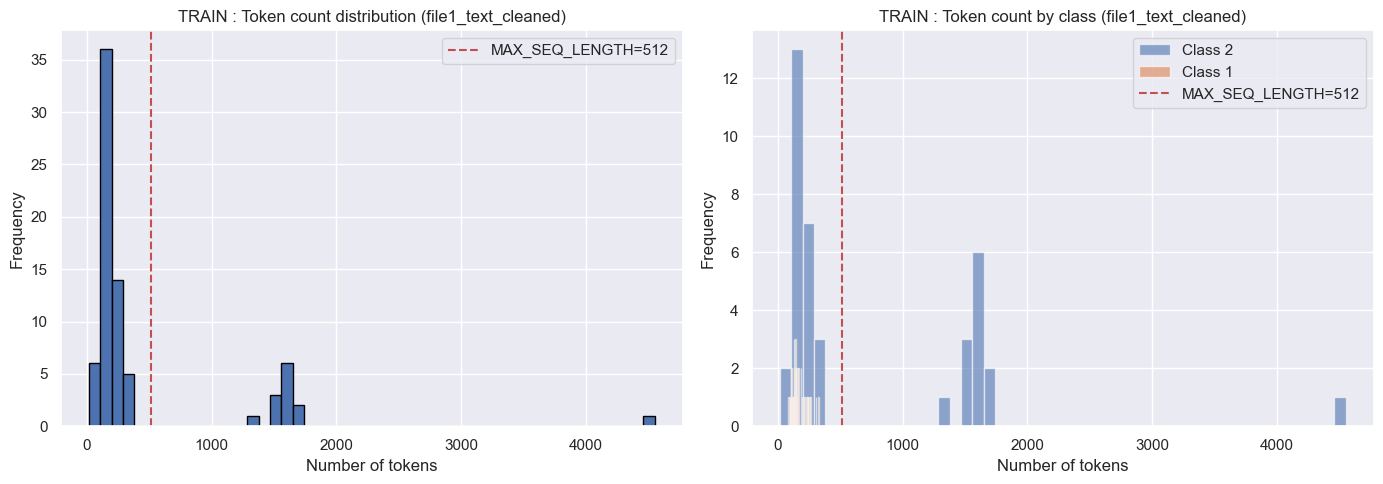


Texts exceeding MAX_SEQ_LENGTH (512) for file1_text_cleaned:
  Count: 13
  Percentage: 17.57%

Tokenizing file2_text_cleaned with distilbert-base-uncased

Token count statistics for file2_text_cleaned:


count      74.000000
mean      264.608108
std       367.700698
min        10.000000
25%       115.000000
50%       169.500000
75%       226.750000
max      1832.000000
Name: file2_text_cleaned_num_tokens_distilbert-base-uncased, dtype: float64

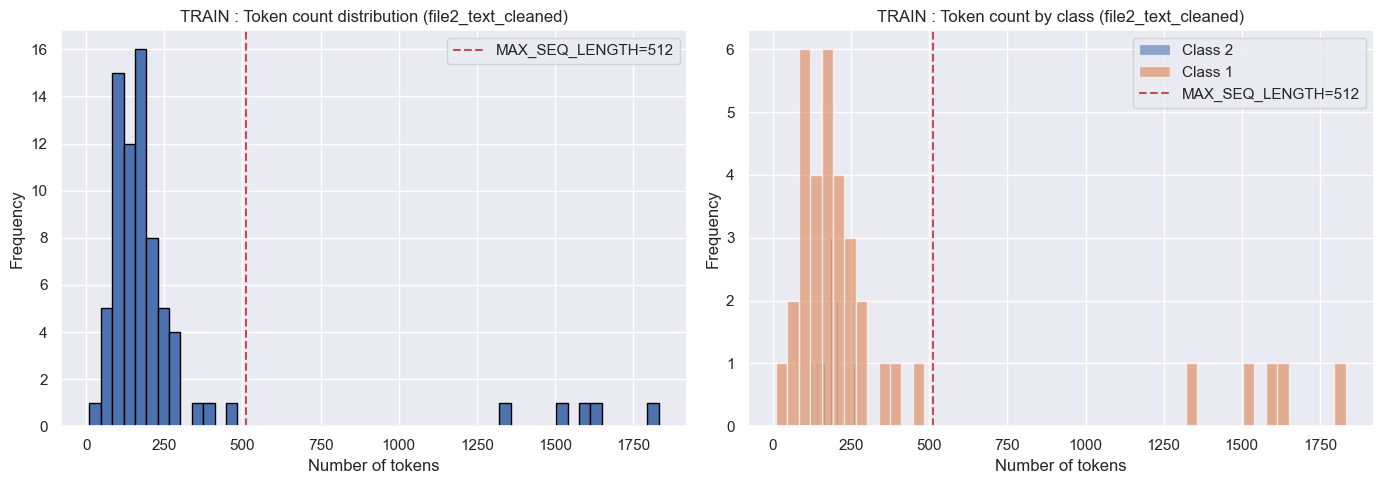


Texts exceeding MAX_SEQ_LENGTH (512) for file2_text_cleaned:
  Count: 5
  Percentage: 6.76%

Chunking texts for TRAIN with distilbert-base-uncased

Example chunking for file1_text_cleaned:


,file1_text_cleaned,file1_text_cleaned_num_tokens_distilbert-base-uncased,file1_text_cleaned_num_chunks_distilbert-base-uncased
0,determine accurate value total lithium abundan...,1331,4
1,megapixel edam camera design fabricate yale un...,247,1
2,undertake two major project use near infrared ...,335,1
3,may polarimetric near infrared measurement det...,1511,4
4,two new science project set period focus study...,1660,4



Example chunking for file2_text_cleaned:


,file2_text_cleaned,file2_text_cleaned_num_tokens_distilbert-base-uncased,file2_text_cleaned_num_chunks_distilbert-base-uncased
0,determine accurate value total lithium abundan...,280,1
1,qu camera megapixel create yale university hel...,165,1
2,vlt enable two major project use sinfoni instr...,176,1
3,may polarimetric near infrared nir measurement...,244,1
4,two new science project schedule period includ...,150,1



=== Processing VALIDATION ===

Tokenizing file1_text_cleaned with distilbert-base-uncased

Token count statistics for file1_text_cleaned:


count     19.000000
mean     195.947368
std       72.549197
min      111.000000
25%      154.000000
50%      185.000000
75%      207.500000
max      414.000000
Name: file1_text_cleaned_num_tokens_distilbert-base-uncased, dtype: float64

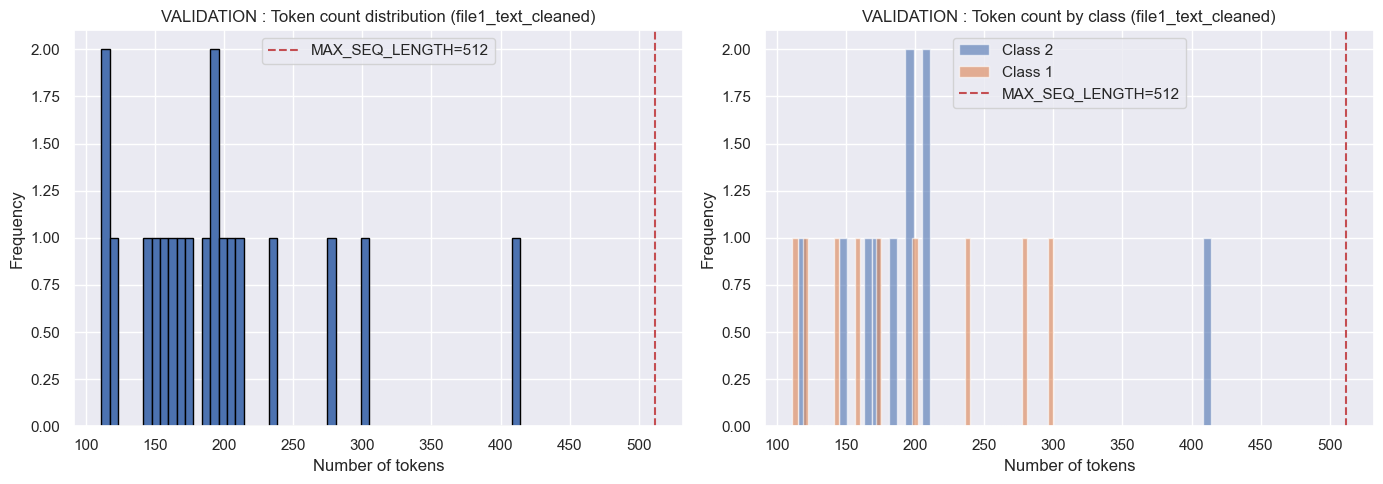


Texts exceeding MAX_SEQ_LENGTH (512) for file1_text_cleaned:
  Count: 0
  Percentage: 0.00%

Tokenizing file2_text_cleaned with distilbert-base-uncased

Token count statistics for file2_text_cleaned:


count      19.000000
mean      220.842105
std       301.641300
min        45.000000
25%       112.500000
50%       139.000000
75%       192.500000
max      1438.000000
Name: file2_text_cleaned_num_tokens_distilbert-base-uncased, dtype: float64

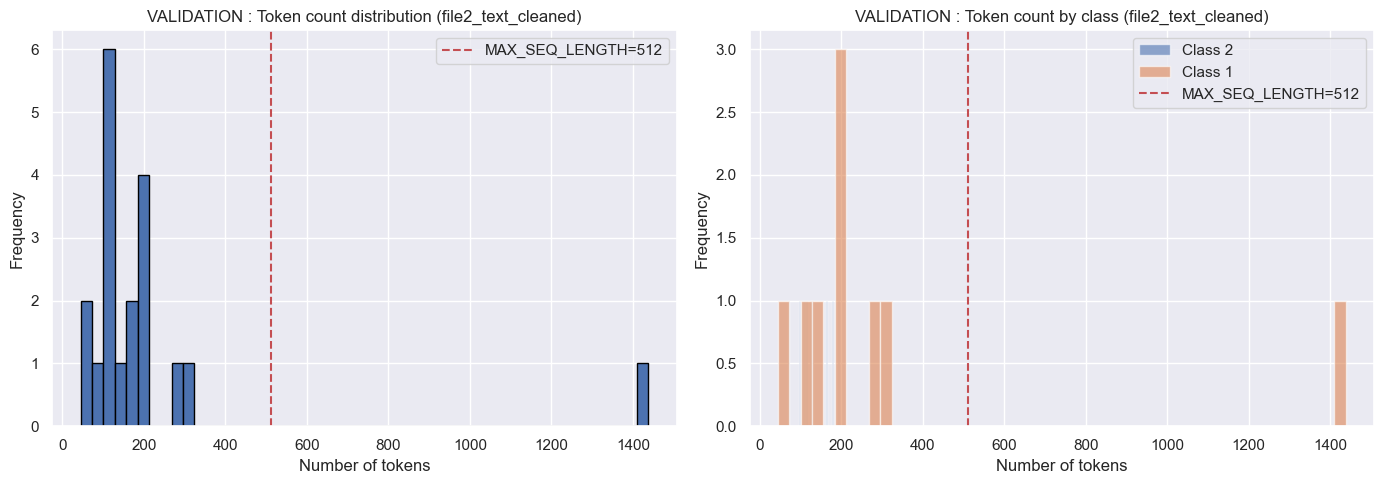


Texts exceeding MAX_SEQ_LENGTH (512) for file2_text_cleaned:
  Count: 1
  Percentage: 5.26%

Chunking texts for VALIDATION with distilbert-base-uncased

Example chunking for file1_text_cleaned:


,file1_text_cleaned,file1_text_cleaned_num_tokens_distilbert-base-uncased,file1_text_cleaned_num_chunks_distilbert-base-uncased
0,peer cosmic abyss unlock secret reionization h...,414,1
1,multi epoch approach demonstrate effectiveness...,278,1
2,china study suggest multiple star system play ...,185,1
3,several experiment use high order telescope ho...,300,1
4,key question cause powerful outflow occur dist...,122,1



Example chunking for file2_text_cleaned:


,file2_text_cleaned,file2_text_cleaned_num_tokens_distilbert-base-uncased,file2_text_cleaned_num_chunks_distilbert-base-uncased
0,understand reionization universe aid study dis...,163,1
1,ancient civilization leave incredible monument...,127,1
2,importance understand star evolve lead researc...,194,1
3,within vibrant realm astronomical observation ...,305,1
4,burn question fuel powerful stellar wind early...,191,1


Token indices sequence length is longer than the specified maximum sequence length for this model (1331 > 512). Running this sequence through the model will result in indexing errors


TOKENIZER COMPARISON: BERT-BASE-UNCASED
Vocabulary size: 30522

=== Processing TRAIN ===

Tokenizing file1_text_cleaned with bert-base-uncased

Token count statistics for file1_text_cleaned:


count      74.000000
mean      461.324324
std       709.127442
min        17.000000
25%       135.500000
50%       185.500000
75%       283.000000
max      4552.000000
Name: file1_text_cleaned_num_tokens_bert-base-uncased, dtype: float64

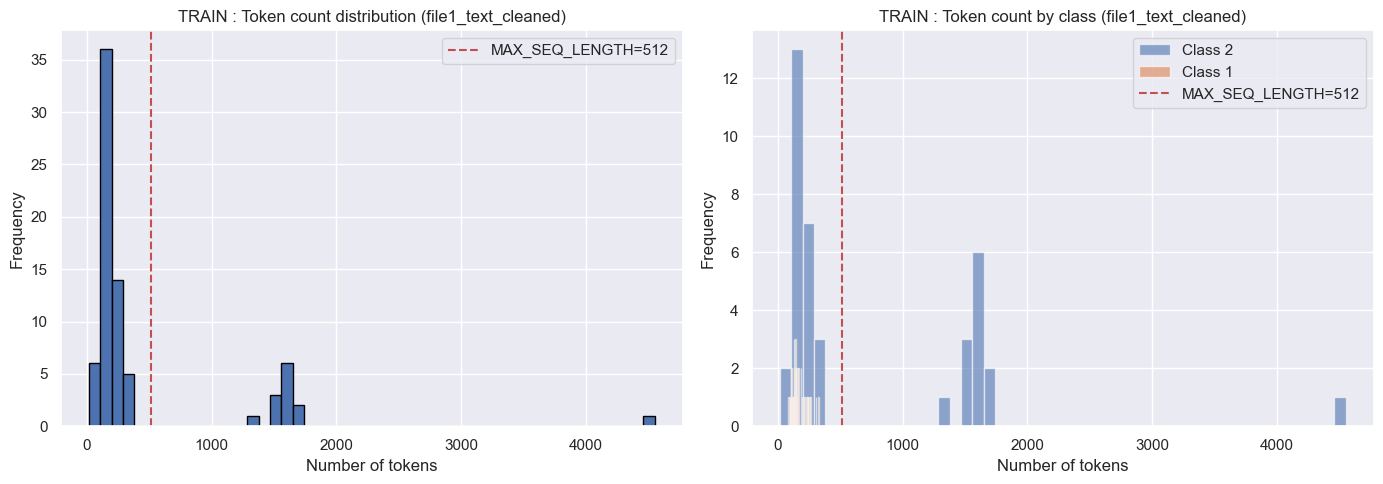


Texts exceeding MAX_SEQ_LENGTH (512) for file1_text_cleaned:
  Count: 13
  Percentage: 17.57%

Tokenizing file2_text_cleaned with bert-base-uncased

Token count statistics for file2_text_cleaned:


count      74.000000
mean      264.608108
std       367.700698
min        10.000000
25%       115.000000
50%       169.500000
75%       226.750000
max      1832.000000
Name: file2_text_cleaned_num_tokens_bert-base-uncased, dtype: float64

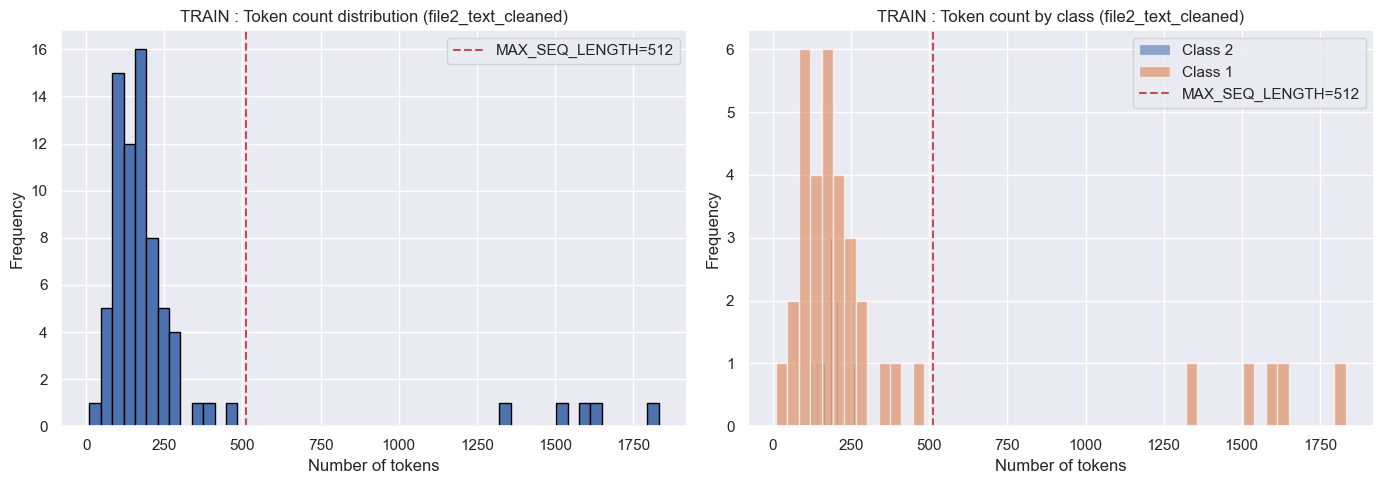


Texts exceeding MAX_SEQ_LENGTH (512) for file2_text_cleaned:
  Count: 5
  Percentage: 6.76%

Chunking texts for TRAIN with bert-base-uncased

Example chunking for file1_text_cleaned:


,file1_text_cleaned,file1_text_cleaned_num_tokens_bert-base-uncased,file1_text_cleaned_num_chunks_bert-base-uncased
0,determine accurate value total lithium abundan...,1331,4
1,megapixel edam camera design fabricate yale un...,247,1
2,undertake two major project use near infrared ...,335,1
3,may polarimetric near infrared measurement det...,1511,4
4,two new science project set period focus study...,1660,4



Example chunking for file2_text_cleaned:


,file2_text_cleaned,file2_text_cleaned_num_tokens_bert-base-uncased,file2_text_cleaned_num_chunks_bert-base-uncased
0,determine accurate value total lithium abundan...,280,1
1,qu camera megapixel create yale university hel...,165,1
2,vlt enable two major project use sinfoni instr...,176,1
3,may polarimetric near infrared nir measurement...,244,1
4,two new science project schedule period includ...,150,1



=== Processing VALIDATION ===

Tokenizing file1_text_cleaned with bert-base-uncased

Token count statistics for file1_text_cleaned:


count     19.000000
mean     195.947368
std       72.549197
min      111.000000
25%      154.000000
50%      185.000000
75%      207.500000
max      414.000000
Name: file1_text_cleaned_num_tokens_bert-base-uncased, dtype: float64

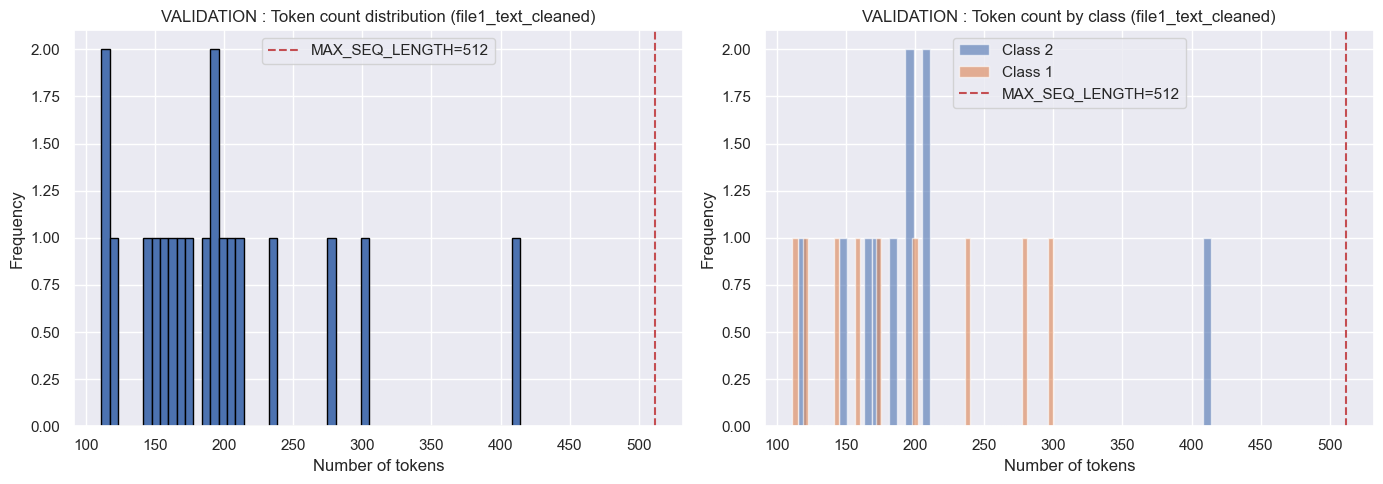


Texts exceeding MAX_SEQ_LENGTH (512) for file1_text_cleaned:
  Count: 0
  Percentage: 0.00%

Tokenizing file2_text_cleaned with bert-base-uncased

Token count statistics for file2_text_cleaned:


count      19.000000
mean      220.842105
std       301.641300
min        45.000000
25%       112.500000
50%       139.000000
75%       192.500000
max      1438.000000
Name: file2_text_cleaned_num_tokens_bert-base-uncased, dtype: float64

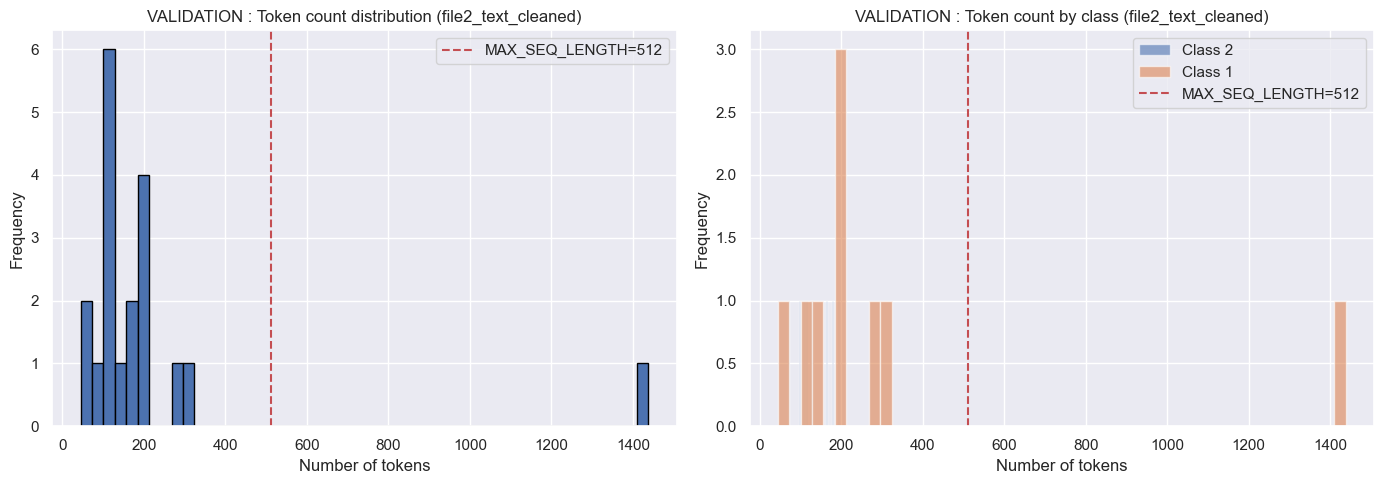


Texts exceeding MAX_SEQ_LENGTH (512) for file2_text_cleaned:
  Count: 1
  Percentage: 5.26%

Chunking texts for VALIDATION with bert-base-uncased

Example chunking for file1_text_cleaned:


,file1_text_cleaned,file1_text_cleaned_num_tokens_bert-base-uncased,file1_text_cleaned_num_chunks_bert-base-uncased
0,peer cosmic abyss unlock secret reionization h...,414,1
1,multi epoch approach demonstrate effectiveness...,278,1
2,china study suggest multiple star system play ...,185,1
3,several experiment use high order telescope ho...,300,1
4,key question cause powerful outflow occur dist...,122,1



Example chunking for file2_text_cleaned:


,file2_text_cleaned,file2_text_cleaned_num_tokens_bert-base-uncased,file2_text_cleaned_num_chunks_bert-base-uncased
0,understand reionization universe aid study dis...,163,1
1,ancient civilization leave incredible monument...,127,1
2,importance understand star evolve lead researc...,194,1
3,within vibrant realm astronomical observation ...,305,1
4,burn question fuel powerful stellar wind early...,191,1


TOKENIZER COMPARISON: ROBERTA-BASE


Token indices sequence length is longer than the specified maximum sequence length for this model (1252 > 512). Running this sequence through the model will result in indexing errors


Vocabulary size: 50265

=== Processing TRAIN ===

Tokenizing file1_text_cleaned with roberta-base

Token count statistics for file1_text_cleaned:


count      74.000000
mean      444.351351
std       663.304067
min        19.000000
25%       136.500000
50%       185.500000
75%       278.250000
max      4242.000000
Name: file1_text_cleaned_num_tokens_roberta-base, dtype: float64

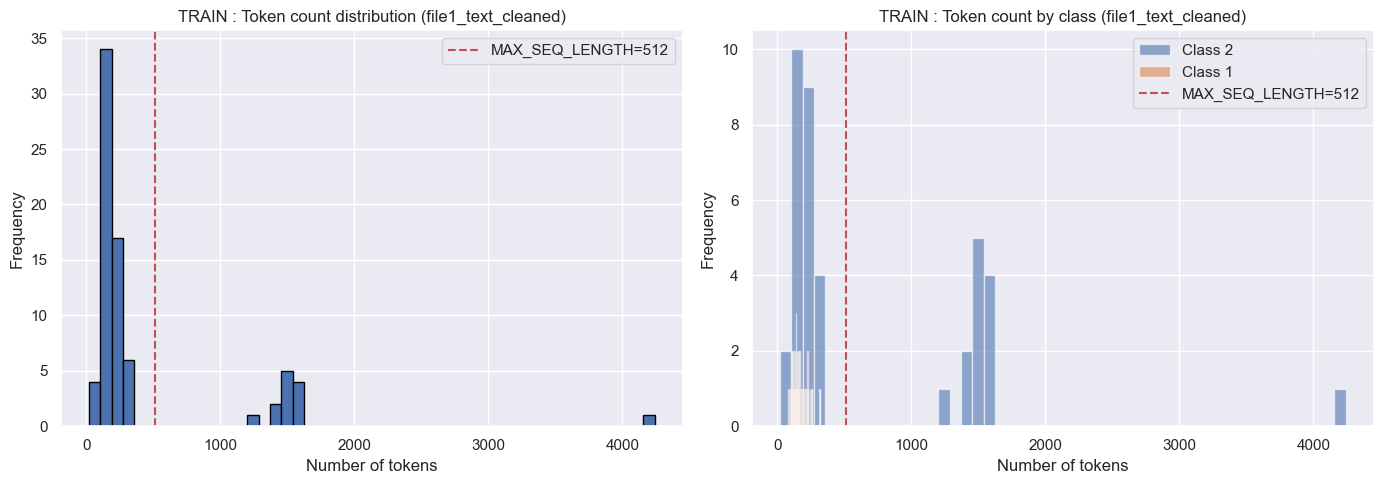


Texts exceeding MAX_SEQ_LENGTH (512) for file1_text_cleaned:
  Count: 13
  Percentage: 17.57%

Tokenizing file2_text_cleaned with roberta-base

Token count statistics for file2_text_cleaned:


count      74.000000
mean      259.148649
std       345.858221
min        12.000000
25%       118.250000
50%       168.500000
75%       229.500000
max      1741.000000
Name: file2_text_cleaned_num_tokens_roberta-base, dtype: float64

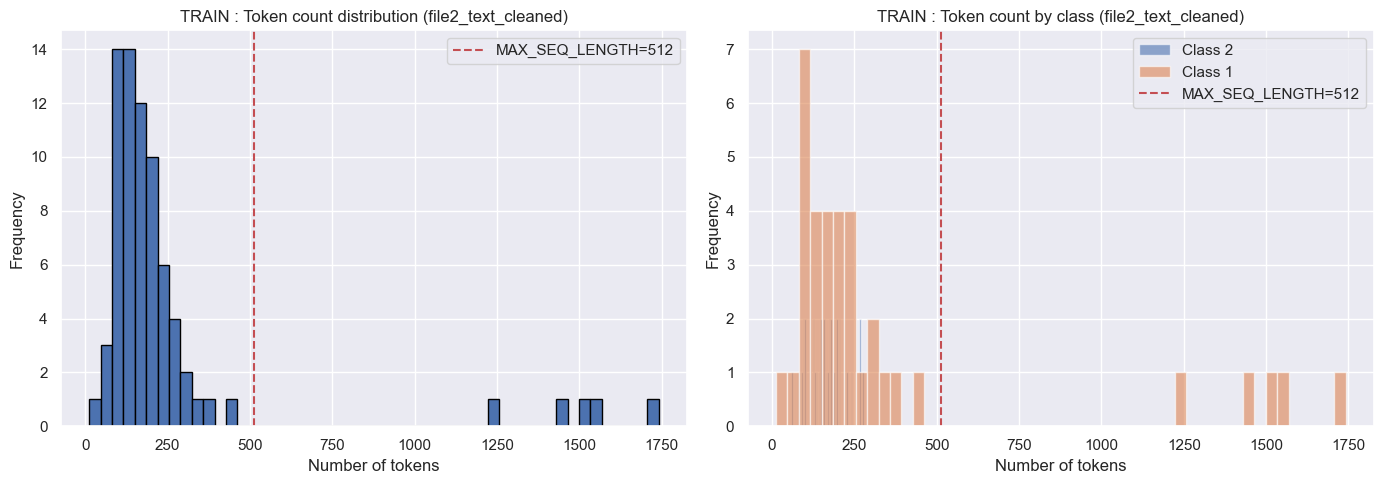


Texts exceeding MAX_SEQ_LENGTH (512) for file2_text_cleaned:
  Count: 5
  Percentage: 6.76%

Chunking texts for TRAIN with roberta-base

Example chunking for file1_text_cleaned:


,file1_text_cleaned,file1_text_cleaned_num_tokens_roberta-base,file1_text_cleaned_num_chunks_roberta-base
0,determine accurate value total lithium abundan...,1252,3
1,megapixel edam camera design fabricate yale un...,245,1
2,undertake two major project use near infrared ...,332,1
3,may polarimetric near infrared measurement det...,1422,4
4,two new science project set period focus study...,1581,4



Example chunking for file2_text_cleaned:


,file2_text_cleaned,file2_text_cleaned_num_tokens_roberta-base,file2_text_cleaned_num_chunks_roberta-base
0,determine accurate value total lithium abundan...,278,1
1,qu camera megapixel create yale university hel...,166,1
2,vlt enable two major project use sinfoni instr...,172,1
3,may polarimetric near infrared nir measurement...,240,1
4,two new science project schedule period includ...,150,1



=== Processing VALIDATION ===

Tokenizing file1_text_cleaned with roberta-base

Token count statistics for file1_text_cleaned:


count     19.000000
mean     194.894737
std       69.856118
min      108.000000
25%      155.500000
50%      186.000000
75%      203.000000
max      401.000000
Name: file1_text_cleaned_num_tokens_roberta-base, dtype: float64

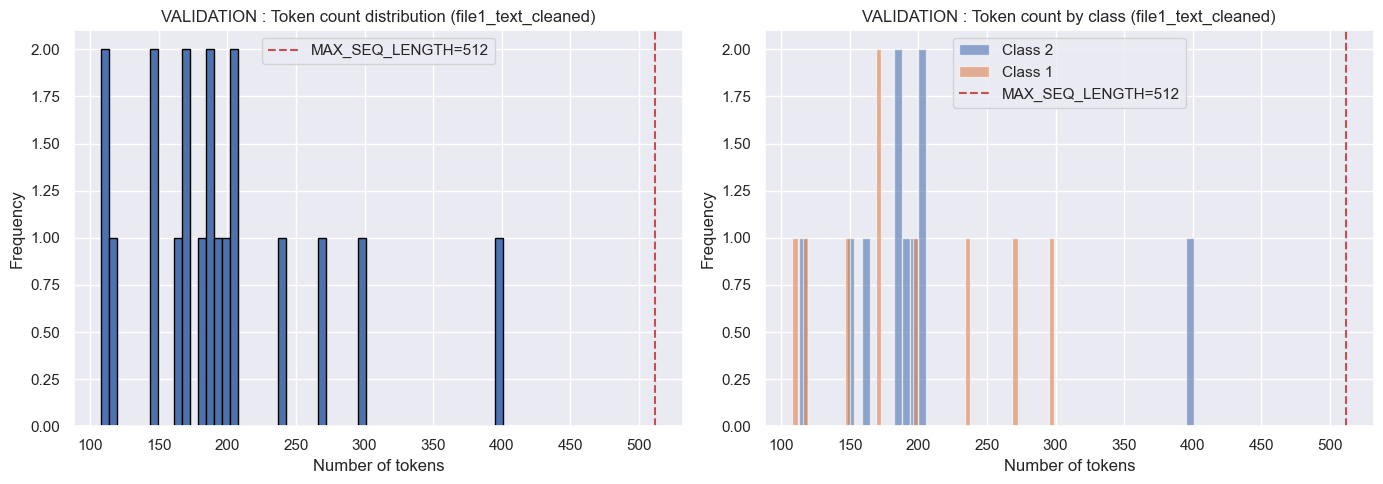


Texts exceeding MAX_SEQ_LENGTH (512) for file1_text_cleaned:
  Count: 0
  Percentage: 0.00%

Tokenizing file2_text_cleaned with roberta-base

Token count statistics for file2_text_cleaned:


count      19.000000
mean      214.631579
std       281.207162
min        49.000000
25%       116.000000
50%       133.000000
75%       188.000000
max      1347.000000
Name: file2_text_cleaned_num_tokens_roberta-base, dtype: float64

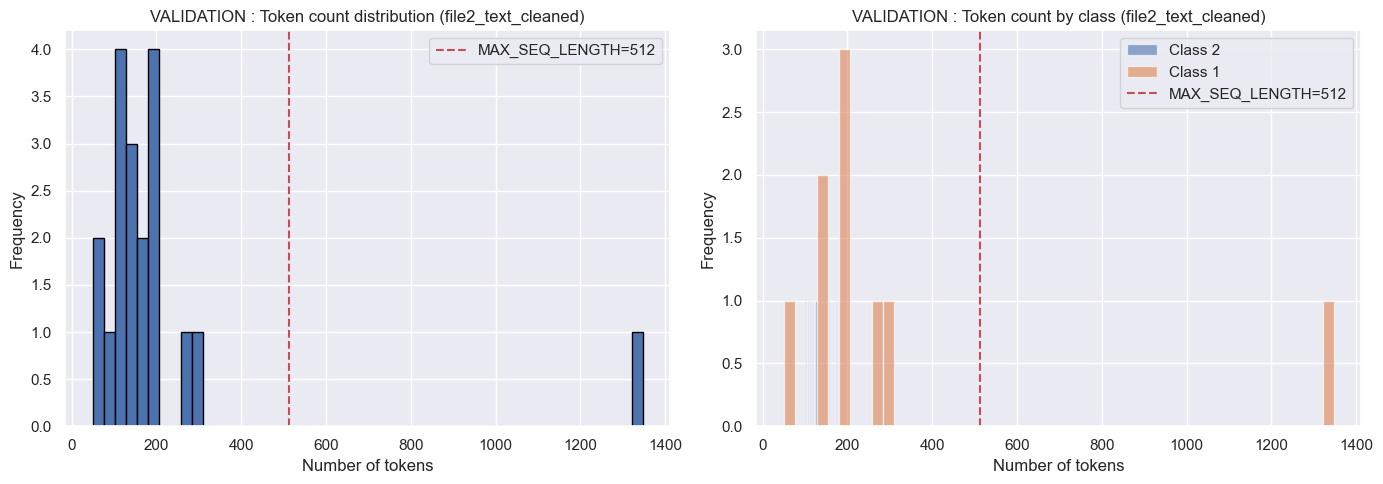


Texts exceeding MAX_SEQ_LENGTH (512) for file2_text_cleaned:
  Count: 1
  Percentage: 5.26%

Chunking texts for VALIDATION with roberta-base

Example chunking for file1_text_cleaned:


,file1_text_cleaned,file1_text_cleaned_num_tokens_roberta-base,file1_text_cleaned_num_chunks_roberta-base
0,peer cosmic abyss unlock secret reionization h...,401,1
1,multi epoch approach demonstrate effectiveness...,270,1
2,china study suggest multiple star system play ...,194,1
3,several experiment use high order telescope ho...,299,1
4,key question cause powerful outflow occur dist...,119,1



Example chunking for file2_text_cleaned:


,file2_text_cleaned,file2_text_cleaned_num_tokens_roberta-base,file2_text_cleaned_num_chunks_roberta-base
0,understand reionization universe aid study dis...,157,1
1,ancient civilization leave incredible monument...,129,1
2,importance understand star evolve lead researc...,194,1
3,within vibrant realm astronomical observation ...,301,1
4,burn question fuel powerful stellar wind early...,182,1


In [8]:
tokenizers_to_test = [
    'distilbert-base-uncased',
    'bert-base-uncased',
    'roberta-base'
]

MAX_LEN = config.MAX_SEQ_LENGTH
OVERLAP = 128

# Loop over tokenizers
for tokenizer_name in tokenizers_to_test:
    print("="*80)
    print(f"TOKENIZER COMPARISON: {tokenizer_name.upper()}")
    print("="*80)

    tok = AutoTokenizer.from_pretrained(tokenizer_name)
    print(f"Vocabulary size: {tok.vocab_size}")

    # Function to analyze & chunk like before
    def analyze_and_chunk_multi(df, df_name, tokenizer, max_len, overlap):
        print(f"\n=== Processing {df_name} ===")

        for col in ['file1_text_cleaned', 'file2_text_cleaned']:
            print(f"\nTokenizing {col} with {tokenizer_name}")
            df[f'{col}_tokens_{tokenizer_name}'] = df[col].apply(lambda x: tokenizer.tokenize(x))
            df[f'{col}_num_tokens_{tokenizer_name}'] = df[f'{col}_tokens_{tokenizer_name}'].apply(len)

            print(f"\nToken count statistics for {col}:")
            display(df[f'{col}_num_tokens_{tokenizer_name}'].describe())

            # Plots
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            axes[0].hist(df[f'{col}_num_tokens_{tokenizer_name}'], bins=50, edgecolor='black')
            axes[0].axvline(max_len, color='r', linestyle='--', label=f'MAX_SEQ_LENGTH={max_len}')
            axes[0].set_xlabel('Number of tokens')
            axes[0].set_ylabel('Frequency')
            axes[0].set_title(f'{df_name} : Token count distribution ({col})')
            axes[0].legend()

            for label in df['real_text_id'].unique():
                data = df[df['real_text_id'] == label][f'{col}_num_tokens_{tokenizer_name}']
                axes[1].hist(data, alpha=0.6, label=f'Class {label}', bins=50)
            axes[1].axvline(max_len, color='r', linestyle='--', label=f'MAX_SEQ_LENGTH={max_len}')
            axes[1].set_xlabel('Number of tokens')
            axes[1].set_ylabel('Frequency')
            axes[1].set_title(f'{df_name} : Token count by class ({col})')
            axes[1].legend()
            plt.tight_layout()
            plt.show()

            # Texts exceeding max length
            num_exceeding = (df[f'{col}_num_tokens_{tokenizer_name}'] > max_len).sum()
            pct_exceeding = 100 * num_exceeding / len(df)
            print(f"\nTexts exceeding MAX_SEQ_LENGTH ({max_len}) for {col}:")
            print(f"  Count: {num_exceeding}")
            print(f"  Percentage: {pct_exceeding:.2f}%")

        # Chunking
        def chunk_text(text, tokenizer, max_length=max_len, overlap=overlap):
            tokens = tokenizer.tokenize(text)
            if len(tokens) <= max_length:
                return [text]
            chunks = []
            for i in range(0, len(tokens), max_length - overlap):
                chunk_tokens = tokens[i:i + max_length]
                chunk_text = tokenizer.convert_tokens_to_string(chunk_tokens)
                chunks.append(chunk_text)
                if i + max_length >= len(tokens):
                    break
            return chunks

        print(f"\nChunking texts for {df_name} with {tokenizer_name}")
        for col in ['file1_text_cleaned', 'file2_text_cleaned']:
            df[f'{col}_chunks_{tokenizer_name}'] = df[col].apply(lambda x: chunk_text(x, tokenizer, max_len, overlap))
            df[f'{col}_num_chunks_{tokenizer_name}'] = df[f'{col}_chunks_{tokenizer_name}'].apply(len)
            print(f"\nExample chunking for {col}:")
            display(df[[col, f'{col}_num_tokens_{tokenizer_name}', f'{col}_num_chunks_{tokenizer_name}']].head())

        return df

    # Run on both datasets
    train_df = analyze_and_chunk_multi(train_df, "TRAIN", tok, MAX_LEN, OVERLAP)
    val_df = analyze_and_chunk_multi(val_df, "VALIDATION", tok, MAX_LEN, OVERLAP)


1. Vocabulary size : Given a model, how many words can be represented by the different tokens of model
- DistilBERT / BERT: 30,522 tokens
- RoBERTa: 50,265 tokens

2. Token count statistics (for train_df, file1 and file2)

| Tokenizer  | file1 mean tokens | file1 max tokens | file2 mean tokens | file2 max tokens |
| ---------- | ----------------- | ---------------- | ----------------- | ---------------- |
| DistilBERT | 461               | 4552             | 265               | 1832             |
| BERT       | 461               | 4552             | 265               | 1832             |
| RoBERTa    | 444               | 4242             | 259               | 1741             |

- RoBERTa produces slightly fewer tokens on average, which means less truncation and slightly smaller input sequences
- Max token counts are all far above 512 so chunking will still be necessary for long texts

3. Percentage of texts exceeding MAX_SEQ_LENGTH=512

| Tokenizer  | file1 (%) | file2 (%) |
| ---------- | --------- | --------- |
| DistilBERT | 17.57%    | 6.76%     |
| BERT       | 17.57%    | 6.76%     |
| RoBERTa    | 17.57%    | 6.76%     |

- Very similar behavior across all three models
- Long texts will need chunking anyway

4. Chunking results

- All tokenizers chunk very long texts similarly
- RoBERTa sometimes produces slightly fewer chunks for very long sequences (eg, first text from train_df: for 1253 tokens, only 3 chunks vs 1331 tokens for 4 chunks for DistilBERT/BERT). It's slightly more efficient for very long documents

Usually, I would pick RoBERTa since it has larger vocab, slightly fewer tokens and more "modern" pretraining (more robust to unknows) but since it's an ESA competition so space field context I will reconsider using RoBERTa and care about GPU/CPU memory usage, processing time and tokenization efficiency.

In fact, if GPU memory is limited (4-8 GB), I'd pick DistilBERT-base-uncased (lightweight and robust) but if GPU memory can be turned up to 12 GB, I'd pick RoBERTa-base for a better accuracy (slightly slower but more expressive)

# Drop and rename columns

In [9]:
cols_to_keep = [
    'real_text_id', 'file1_text', 'file2_text',
    'file1_char_len', 'file2_char_len',
    'file1_word_len', 'file2_word_len',
    'combined_text',
    'file1_text_cleaned', 'file2_text_cleaned',
    'file1_text_cleaned_tokens_distilbert-base-uncased',
    'file1_text_cleaned_num_tokens_distilbert-base-uncased',
    'file2_text_cleaned_tokens_distilbert-base-uncased',
    'file2_text_cleaned_num_tokens_distilbert-base-uncased',
    'file1_text_cleaned_chunks_distilbert-base-uncased',
    'file1_text_cleaned_num_chunks_distilbert-base-uncased',
    'file2_text_cleaned_chunks_distilbert-base-uncased',
    'file2_text_cleaned_num_chunks_distilbert-base-uncased'
]

train_df = train_df[cols_to_keep].copy()
val_df = val_df[cols_to_keep].copy()

rename_map = {
    'file1_text_cleaned_tokens_distilbert-base-uncased': 'file1_text_cleaned_tokens',
    'file1_text_cleaned_num_tokens_distilbert-base-uncased': 'file1_text_cleaned_num_tokens',
    'file2_text_cleaned_tokens_distilbert-base-uncased': 'file2_text_cleaned_tokens',
    'file2_text_cleaned_num_tokens_distilbert-base-uncased': 'file2_text_cleaned_num_tokens',
    'file1_text_cleaned_chunks_distilbert-base-uncased': 'file1_text_cleaned_chunks',
    'file1_text_cleaned_num_chunks_distilbert-base-uncased': 'file1_text_cleaned_num_chunks',
    'file2_text_cleaned_chunks_distilbert-base-uncased': 'file2_text_cleaned_chunks',
    'file2_text_cleaned_num_chunks_distilbert-base-uncased': 'file2_text_cleaned_num_chunks'
}

train_df.rename(columns=rename_map, inplace=True)
val_df.rename(columns=rename_map, inplace=True)

# Exploding chunks

In order to feed the future model, I need to make each chunk becomes its own row

In [10]:
exploded_dfs = {}

for df, name in zip([train_df, val_df], ['TRAIN', 'VALIDATION']):
    exploded_list = []
    
    for col in ['file1_text_cleaned_chunks', 'file2_text_cleaned_chunks']:
        temp_df = df.copy()
        temp_df['text_chunk'] = temp_df[col]
        temp_df = temp_df.explode('text_chunk').reset_index(drop=True)
        temp_df['source'] = col.replace('_text_cleaned_chunks', '')  # file1/file2
        exploded_list.append(temp_df)
    
    # Concatenate all exploded columns
    exploded_df = pd.concat(exploded_list, ignore_index=True)
    
    print(f"{name} set: original rows = {len(df)}, exploded rows = {len(exploded_df)}")
    exploded_dfs[name] = exploded_df

# Assign back to variables if needed
train_df_exploded = exploded_dfs['TRAIN']
val_df_exploded = exploded_dfs['VALIDATION']

# Quick check
display(train_df_exploded.head())
display(val_df_exploded.head())

TRAIN set: original rows = 74, exploded rows = 212
VALIDATION set: original rows = 19, exploded rows = 41


,real_text_id,file1_text,file2_text,file1_char_len,file2_char_len,file1_word_len,file2_word_len,combined_text,file1_text_cleaned,file2_text_cleaned,file1_text_cleaned_tokens,file1_text_cleaned_num_tokens,file2_text_cleaned_tokens,file2_text_cleaned_num_tokens,file1_text_cleaned_chunks,file1_text_cleaned_num_chunks,file2_text_cleaned_chunks,file2_text_cleaned_num_chunks,text_chunk,source
0,2,We determine accurate values for the total lit...,We determine accurate values for the total lit...,7101,2525,751,406,We determine accurate values for the total lit...,determine accurate value total lithium abundan...,determine accurate value total lithium abundan...,"[determine, accurate, value, total, lithium, a...",1331,"[determine, accurate, value, total, lithium, a...",280,[determine accurate value total lithium abunda...,4,[determine accurate value total lithium abunda...,1,determine accurate value total lithium abundan...,file1
1,2,We determine accurate values for the total lit...,We determine accurate values for the total lit...,7101,2525,751,406,We determine accurate values for the total lit...,determine accurate value total lithium abundan...,determine accurate value total lithium abundan...,"[determine, accurate, value, total, lithium, a...",1331,"[determine, accurate, value, total, lithium, a...",280,[determine accurate value total lithium abunda...,4,[determine accurate value total lithium abunda...,1,resultantkan usp mind lux color hotel empirica...,file1
2,2,We determine accurate values for the total lit...,We determine accurate values for the total lit...,7101,2525,751,406,We determine accurate values for the total lit...,determine accurate value total lithium abundan...,determine accurate value total lithium abundan...,"[determine, accurate, value, total, lithium, a...",1331,"[determine, accurate, value, total, lithium, a...",280,[determine accurate value total lithium abunda...,4,[determine accurate value total lithium abunda...,1,lantern einen histor cean gemusept replacequis...,file1
3,2,We determine accurate values for the total lit...,We determine accurate values for the total lit...,7101,2525,751,406,We determine accurate values for the total lit...,determine accurate value total lithium abundan...,determine accurate value total lithium abundan...,"[determine, accurate, value, total, lithium, a...",1331,"[determine, accurate, value, total, lithium, a...",280,[determine accurate value total lithium abunda...,4,[determine accurate value total lithium abunda...,1,##igero centerall omgevingtocol lacao lamidora...,file1
4,2,The 160-megapixel **Edam** camera was designed...,The QUEST camera has 160 megapixels and was cr...,2076,1368,337,219,The 160-megapixel **Edam** camera was designed...,megapixel edam camera design fabricate yale un...,qu camera megapixel create yale university hel...,"[mega, ##pi, ##x, ##el, ed, ##am, camera, desi...",247,"[qu, camera, mega, ##pi, ##x, ##el, create, ya...",165,[megapixel edam camera design fabricate yale u...,1,[qu camera megapixel create yale university he...,1,megapixel edam camera design fabricate yale un...,file1


,real_text_id,file1_text,file2_text,file1_char_len,file2_char_len,file1_word_len,file2_word_len,combined_text,file1_text_cleaned,file2_text_cleaned,file1_text_cleaned_tokens,file1_text_cleaned_num_tokens,file2_text_cleaned_tokens,file2_text_cleaned_num_tokens,file1_text_cleaned_chunks,file1_text_cleaned_num_chunks,file2_text_cleaned_chunks,file2_text_cleaned_num_chunks,text_chunk,source
0,2,## Peering into the Cosmic Abyss: Unlocking th...,Understanding the reionization of the universe...,3770,1406,576,219,## Peering into the Cosmic Abyss: Unlocking th...,peer cosmic abyss unlock secret reionization h...,understand reionization universe aid study dis...,"[peer, cosmic, abyss, unlock, secret, rei, ##o...",414,"[understand, rei, ##oni, ##zation, universe, a...",163,[peer cosmic abyss unlock secret reionization ...,1,[understand reionization universe aid study di...,1,peer cosmic abyss unlock secret reionization h...,file1
1,1,The multi-epoch approach has demonstrated its ...,Ancient civilizations left us not just incredi...,2720,1346,383,208,The multi-epoch approach has demonstrated its ...,multi epoch approach demonstrate effectiveness...,ancient civilization leave incredible monument...,"[multi, epoch, approach, demonstrate, effectiv...",278,"[ancient, civilization, leave, incredible, mon...",127,[multi epoch approach demonstrate effectivenes...,1,[ancient civilization leave incredible monumen...,1,multi epoch approach demonstrate effectiveness...,file1
2,2,China\nThe study suggests that multiple star s...,The importance for understanding how stars evo...,1774,1869,263,262,China\nThe study suggests that multiple star s...,china study suggest multiple star system play ...,importance understand star evolve lead researc...,"[china, study, suggest, multiple, star, system...",185,"[importance, understand, star, evolve, lead, r...",194,[china study suggest multiple star system play...,1,[importance understand star evolve lead resear...,1,china study suggest multiple star system play ...,file1
3,1,Several experiments using the High Order Teles...,Within the vibrant realm of astronomical obser...,2591,2784,379,395,Several experiments using the High Order Teles...,several experiment use high order telescope ho...,within vibrant realm astronomical observation ...,"[several, experiment, use, high, order, telesc...",300,"[within, vibrant, realm, astronomical, observa...",305,[several experiment use high order telescope h...,1,[within vibrant realm astronomical observation...,1,several experiment use high order telescope ho...,file1
4,1,A key question is what causes powerful outflow...,A burning question for us is what fuels the mo...,1066,1791,158,281,A key question is what causes powerful outflow...,key question cause powerful outflow occur dist...,burn question fuel powerful stellar wind early...,"[key, question, cause, powerful, out, ##flow, ...",122,"[burn, question, fuel, powerful, stellar, wind...",191,[key question cause powerful outflow occur dis...,1,[burn question fuel powerful stellar wind earl...,1,key question cause powerful outflow occur dist...,file1


# Add label column

In [11]:
def create_label(row):
    # Check if the chunk's source file is the real one
    is_real_text = (row['source'] == 'file1' and row['real_text_id'] == 1) or \
                   (row['source'] == 'file2' and row['real_text_id'] == 2)
    return 1 if is_real_text else 0

# Apply the function to create the 'label' column
train_df_exploded['label'] = train_df_exploded.apply(create_label, axis=1)
val_df_exploded['label'] = val_df_exploded.apply(create_label, axis=1)

# Data quality check

In [12]:
for df, name in zip([train_df_exploded, val_df_exploded], ['TRAIN', 'VALIDATION']):
    print("=" * 80)
    print(f"DATA QUALITY CHECKS ({name} SET)")
    print("=" * 80)
    
    for col in ['text_chunk']:
        print("-" * 80)
        print(f"Column: {col}")
        print("-" * 80)
        
        # Empty texts
        empty_mask = df[col].apply(lambda x: len(x) == 0 if isinstance(x, list) else pd.isna(x))
        print(f"Empty texts after preprocessing: {empty_mask.sum()}")

        # Duplicates
        duplicates = df.duplicated(subset=[col])
        print(f"Duplicate texts: {duplicates.sum()}")

        # Class distribution
        print("\nClass distribution:")
        print(df['real_text_id'].value_counts())

        # Remove problematic samples
        df_clean = df[~empty_mask].copy()
        print(f"Samples after removing empty texts: {len(df_clean)}")

        # Optional summary
        print("\nSample size summary:")
        print(f"  Original size: {len(df)}")
        print(f"  After cleaning: {len(df_clean)}")
        print(f"  Empty removed: {empty_mask.sum()}")
        print(f"  Duplicates detected: {duplicates.sum()}")

DATA QUALITY CHECKS (TRAIN SET)
--------------------------------------------------------------------------------
Column: text_chunk
--------------------------------------------------------------------------------
Empty texts after preprocessing: 0
Duplicate texts: 0

Class distribution:
real_text_id
2    124
1     88
Name: count, dtype: int64
Samples after removing empty texts: 212

Sample size summary:
  Original size: 212
  After cleaning: 212
  Empty removed: 0
  Duplicates detected: 0
DATA QUALITY CHECKS (VALIDATION SET)
--------------------------------------------------------------------------------
Column: text_chunk
--------------------------------------------------------------------------------
Empty texts after preprocessing: 0
Duplicate texts: 0

Class distribution:
real_text_id
1    21
2    20
Name: count, dtype: int64
Samples after removing empty texts: 41

Sample size summary:
  Original size: 41
  After cleaning: 41
  Empty removed: 0
  Duplicates detected: 0


# Save exploded df

In [13]:
# Save train and validation exploded & cleaned data
train_df_exploded.to_csv(config.PROCESSED_DATA_DIR / "train_exploded.csv", index=False)
val_df_exploded.to_csv(config.PROCESSED_DATA_DIR / "val_exploded.csv", index=False)

print("Files saved in data/processed/")

Files saved in data/processed/


# End of data preprocessing notebook